In [ ]:
import time
import pandas as pd
from zomatopy import Zomato
#get_categories
#get_city_ID
#get_city_name
#get_collections
#get_cuisines
#get_establishment_types
#get_nearby_restaurants
#get_restaurant
#restaurant_search

zconfig = {"user_key":"2dde89df168a9311ecd9f1459126144c"}

## CLEANING CENSUS CITIES

In [ ]:
# Reading raw census data
cscities_df = pd.read_excel('../data/census_cities.xlsx',
                                 skiprows=[0, 1, 2, 792, 793, 794, 795, 796])
cscities_df.rename(columns={'Unnamed: 0': 'Rank', 
                            'Unnamed: 1': 'Geographic Area'}, inplace=True)

# Reading state codes
state_codes = pd.read_csv('../data/state_codes.csv')

In [ ]:
# Cleaning city and prepare merge for state_code
cscities_df['city']  = [city.split(', ')[0] for city in cscities_df['Geographic Area']]
cscities_df['state'] = [city.split(', ')[1] for city in cscities_df['Geographic Area']]
cscities_df = cscities_df.merge(state_codes, how='left', on='state')
assert cscities_df['state_code'].isna().sum()==0, "Check merge"

# Define Zomato city_query
cscities_df['city'] = cscities_df['city'].str.replace('city', '')
cscities_df['city'] = cscities_df['city'].str.replace('(balance)', '')
cscities_df['city'] = cscities_df['city'].str.replace('metropolitan government', '')
cscities_df['city'] = cscities_df['city'].str.replace('metro government', '')
cscities_df['city'] = cscities_df['city'].str.replace('urban county', '')
cscities_df['city'] = cscities_df['city'].str.replace('municipality', '')
cscities_df['city'] = cscities_df['city'].str.replace('consolidated government', '')
cscities_df['city'] = cscities_df['city'].str.replace('unified government', '')
cscities_df['city'] = cscities_df['city'].str.replace('(Ventura)', '')
cscities_df['city'] = cscities_df['city'].str.replace('village', '')
cscities_df['city'] = cscities_df['city'].str.replace('town', '')
cscities_df['city'] = cscities_df['city'].str.replace('(', '')
cscities_df['city'] = cscities_df['city'].str.replace(')', '')
cscities_df['city'] = cscities_df['city'].str.replace('.', '')
cscities_df['city'] = cscities_df['city'].str.replace('  ', ' ')
cscities_df['city_query'] = cscities_df['city'] + cscities_df['state_code']

# Save parsed cscities_df
cscities_df.to_pickle('../results/cscities_df.pkl')

In [ ]:
cscities_df.head()

In [ ]:
def zomato_cities_query(cscities_df, zconfig):
    zomato = Zomato(zconfig)
    
    city_queries = []
    zcity_ids = []
    jsons = []
    for i, row in cscities_df.iterrows():
        print(f"city query {row.city_query}")
        
        # Security saves of Zomato calls
        if i>0 and (i % 10 == 0):
            time.sleep(5)
            zcities_df = pd.DataFrame.from_dict({'zcity_id': zcity_ids, 'json': jsons, 
                                                 'city_query': city_queries})
            zcities_df.to_pickle('../results/zcities_df.pkl')
        
        try:
            zcity_id = zomato.get_city_ID(city_name=row.city_query)

            city_queries += [row.city_query]
            zcity_ids += [zcity_id]
            jsons += [zomato.json]
        except:
            print(f"failed city query {row.city_query}")
            pass
    
    # Final save
    zcities_df = pd.DataFrame.from_dict({'zcity_id': zcity_ids, 'json': jsons, 
                                         'city_query': city_queries})
    zcities_df.to_pickle('../results/zcities_df.pkl')
    return zcities_df

zcities_df = zomato_cities_query(cscities_df, zconfig)

In [ ]:
zcities_df = pd.read_pickle('../results/zcities_df.pkl')

In [ ]:
zcities_df.head()

# CLEANING ZOMATO QUERIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance

In [2]:
cscities_df = pd.read_pickle('../results/cscities_df.pkl')
zcities_df = pd.read_pickle('../results/zcities_df.pkl')

# # Adding census variables to zcities_df
zcities_df = zcities_df.merge(cscities_df[['city_query', 'Census']], on='city_query', how='left')
# zcities_df.rename(columns={'city': 'city_cs', 'state_code': 'state_code_cs'}, inplace=True)
#zcities_df.iloc[zcities_df['Census']=='(X)', 'Census'] = 10000
zcities_df['Census'] = pd.to_numeric(zcities_df['Census'], errors='coerce')
print(f"Census missing cities {sum(np.isnan(zcities_df.Census))}")

Census missing cities 7


In [3]:
def clean_punctuation(my_str):
    my_str = str(my_str).lower()
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in my_str:  
        if ele in punc:  
            my_str = my_str.replace(ele, "")
    my_str = my_str.strip()
    return my_str

def clean_city(city):
    city = clean_punctuation(city)    
    city = city.replace('city', '')
    city = city.replace('(balance)', '')
    city = city.replace('metropolitan government', '')
    city = city.replace('metro government', '')
    city = city.replace('urban county', '')
    city = city.replace('municipality', '')
    city = city.replace('consolidated government', '')
    city = city.replace('unified government', '')
    city = city.replace('(Ventura)', '')
    city = city.replace('village', '')
    city = city.replace('town', '')
    city = city.replace('(', '')
    city = city.replace(')', '')
    city = city.replace('.', '')
    city = city.replace('  ', ' ')
    return city

# get zomato state_codes
def get_city_z(zcities_df, hit=0):
    cities = []
    state_codes = []
    zcity_ids = []
    for idx in range(len(zcities_df)):
        try:
            zcity_id = zcities_df['json'][idx]['location_suggestions'][hit]['id']
            city = zcities_df['json'][idx]['location_suggestions'][hit]['name'][:-4]
            state_code = zcities_df['json'][idx]['location_suggestions'][hit]['state_code']
        except:
            zcity_id = -9999
            city = 'NA'
            state_code = 'NA'

        state_codes.append(state_code)
        zcity_ids.append(zcity_id)
        cities.append(city)
    
    zcities_df[f'city_z{hit}'] = cities
    zcities_df[f'state_code_z{hit}'] = state_codes
    zcities_df[f'city_z{hit}'] = zcities_df[f'city_z{hit}'].apply(lambda x: clean_city(x))
    zcities_df[f'zcity_id{hit}'] = zcity_ids
    
    zcities_df[f'lev_dist{hit}'] = zcities_df.apply(lambda row: levenshtein_distance(row[f'city_z{hit}'],
                                                                                     row['city_cs']),axis=1)
    
    zcities_df[f'hit{hit}'] = ((zcities_df[f'state_code_z{hit}']==zcities_df['state_code_cs']) &\
                      (zcities_df[f'lev_dist{hit}']<=3))*1
    #zcities_df[f'hit0'].plot.hist()
    
    hit_perc = sum(zcities_df[f'hit{hit}'])/len(zcities_df[f'hit{hit}'])
    pop_perc = np.nansum(zcities_df[f'hit{hit}']*zcities_df['Census'])/np.nansum(zcities_df['Census'])
    print('Zomato Hit {} percentage: {} pop_percentage: {}'.format(hit, hit_perc, pop_perc))
    return zcities_df

zcities_df['city_cs'] = zcities_df['city_query'].apply(lambda x: str(x)[:-3])
zcities_df['state_code_cs'] = zcities_df['city_query'].apply(lambda x: str(x)[-2:])
zcities_df['city_cs'] = zcities_df['city_cs'].apply(lambda x: clean_city(x))

zcities_df = get_city_z(zcities_df, hit=0)

Zomato Hit 0 percentage: 0.4410994764397906 pop_percentage: 0.6420544188997349


In [4]:
zcities_clean_df = zcities_df[zcities_df.hit0==1].reset_index()
zcities_clean_df.head()

,index,zcity_id,json,city_query,Census,city_cs,state_code_cs,city_z0,state_code_z0,zcity_id0,lev_dist0,hit0
0,0,-9999,"{'location_suggestions': [{'id': 280, 'name': ...",New York NY,8175133.0,new york,NY,new york,NY,280,1,1
1,1,281,"{'location_suggestions': [{'id': 281, 'name': ...",Los Angeles CA,3792621.0,los angeles,CA,los angeles,CA,281,0,1
2,2,292,"{'location_suggestions': [{'id': 292, 'name': ...",Chicago IL,2695598.0,chicago,IL,chicago,IL,292,0,1
3,3,277,"{'location_suggestions': [{'id': 277, 'name': ...",Houston TX,2099451.0,houston,TX,houston,TX,277,0,1
4,4,301,"{'location_suggestions': [{'id': 301, 'name': ...",Phoenix AZ,1445632.0,phoenix,AZ,phoenix,AZ,301,0,1


In [5]:
def zomato_cuisines_query(df, zconfig):
    zomato = Zomato(zconfig)
    
    zcity_ids = []
    jsons = []
    for i, row in df.iterrows():
        zcity_id = row.zcity_id0
        print(f"city: {row.city_z0} city_id: {zcity_id}")
        
        # Security saves of Zomato calls
        if i>0 and (i % 10 == 0):
            time.sleep(5)
            zcuisines_df = pd.DataFrame.from_dict({'zcity_id': zcity_ids, 'json': jsons})
            zcuisines_df.to_pickle('../results/zcuisines_df.pkl')
        
        try:
            json =zomato.get_cuisines(city_ID=zcity_id)
        
        except:
            print(f"Failed query city: {row.city_z0} city_id: {row.zcity_id0}")
            json = {-999: 'Missing'}
        
        zcity_ids += [zcity_id]
        jsons += [json]
    
    # Final save
    zcuisines_df = pd.DataFrame.from_dict({'zcity_id': zcity_ids, 'json': jsons})
    zcuisines_df.to_pickle('../results/zcuisines_df.pkl')
    #zcuisines_df.to_csv('../results/zcuisines_df.csv')
    return zcuisines_df
        
# zcuisines_df  = zomato_cuisines_query(zcities_clean_df, zconfig)
zcuisines_df = pd.read_pickle('../results/zcuisines_df.pkl')
zcuisines_df.rename(columns={"json": "cuisine_json"}, inplace=True)

In [6]:
zstates_cuisines_df = zcities_clean_df.merge(zcuisines_df, 
                                             left_on='zcity_id0', right_on='zcity_id', how='left')

In [8]:
filter_columns = ['state_code_cs', 'Census', 'city_query', 'cuisine_json']
zstates_cuisines_df = zstates_cuisines_df[filter_columns]

In [88]:
grouped = zstates_cuisines_df.groupby('state_code_cs')

states = []
state_cuisines = []
queried_cities = []
for state, group in grouped:    
    group.reset_index(inplace=True)
    
    cuisines = []
    for idx in range(len(group)):
        cuisines += list(group['cuisine_json'][idx].values())
    
    count_cuisines = np.unique(cuisines, return_counts=True)
    count_cuisines_df = pd.DataFrame({'cuisine': count_cuisines[0],
                                      'count': count_cuisines[1],
                                      'percentage': count_cuisines[1]/np.sum(count_cuisines[1])})
    
    queried_cities += [len(group)]
    state_cuisines += [count_cuisines_df]
    states += [state]

states_df = pd.DataFrame.from_dict({'state_code': states,
                                    'queried_cities': queried_cities,
                                    'state_cuisines': state_cuisines})
# states_df.reset_index(inplace=True)

In [105]:
check_count = states_df.loc[4]

In [106]:
state_code = check_count['state_code']
queried_cities = check_count['queried_cities']
print(f"State : {state_code} Queried Cities {queried_cities}")
check_count['state_cuisines']

State : CA Queried Cities 90


,cuisine,count,percentage
0,Afghan,27,0.005839
1,African,14,0.003028
2,American,90,0.019464
3,Argentine,14,0.003028
4,Armenian,9,0.001946
...,...,...,...
126,Tunisian,1,0.000216
127,Turkish,17,0.003676
128,Vegetarian,62,0.013408
129,Venezuelan,4,0.000865


In [107]:
check_count.to_csv('../results/california.csv')

<AxesSubplot:ylabel='Frequency'>

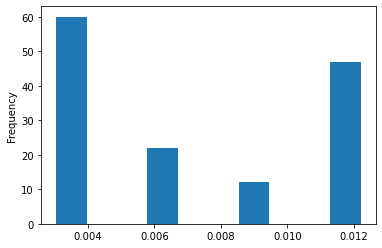

In [97]:
check_count['state_cuisines']['percentage'].plot.hist()

In [22]:
ver = np.unique(ver, return_counts=True)
ver_df = pd.DataFrame({'cuisine': ver[0], 'count': ver[1]})

In [104]:
states_df

,state_code,queried_cities,state_cuisines
0,AK,1,cuisine count percentage 0 Afric...
1,AL,6,cuisine count percentage 0 Afric...
2,AR,3,cuisine count percentage 0 Americ...
3,AZ,12,cuisine count percentage 0 Af...
4,CA,90,cuisine count percentage 0 Af...
5,CO,4,cuisine count percentage 0 Af...
6,DC,1,cuisine count percentage 0 Afgh...
7,DE,1,cuisine count percentage 0 Afgh...
8,FL,14,cuisine count percentage 0 Af...
9,GA,3,cuisine count percentage 0 Af...
